# Importing Libraries and Setting Up Environment

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import tensorflow as tf


# Dataset Paths and Visualization

In [ ]:
# Define paths to the dataset
fire_path = '/content/drive/MyDrive/sdp_wildfire_satellite_shared/azerbaijan_wildfire_imagery/kaggle_fire_dataset_sample/train_dataset/train-wildfire'
nofire_path = '/content/drive/MyDrive/sdp_wildfire_satellite_shared/azerbaijan_wildfire_imagery/kaggle_fire_dataset_sample/train_dataset/train-nowildfire'

# Count images in each class
fire_images = len(os.listdir(fire_path))
nofire_images = len(os.listdir(nofire_path))

# Print dataset information
print(f"Fire Images: {fire_images}")
print(f"No Fire Images: {nofire_images}")

Fire Images: 421
No Fire Images: 420


# Data Preprocessing

In [ ]:
# Define ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split
)

# Load data from directories
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/sdp_wildfire_satellite_shared/azerbaijan_wildfire_imagery/kaggle_fire_dataset_sample/train_dataset',
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/sdp_wildfire_satellite_shared/azerbaijan_wildfire_imagery/kaggle_fire_dataset_sample/train_dataset',
    target_size=(350, 350),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 672 images belonging to 2 classes.
Found 168 images belonging to 2 classes.


# Model Architecture and Compilation

In [ ]:
# Load pretrained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(350, 350, 3))

# Freeze base model layers
base_model.trainable = False

# Define new model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Training the Model

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

# Plot training/validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 423s 19s/step - accuracy: 0.7081 - loss: 16.4144 - val_accuracy: 0.9048 - val_loss: 2.7484 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 356s 17s/step - accuracy: 0.9223 - loss: 2.9689 - val_accuracy: 0.9167 - val_loss: 1.4325 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 379s 16s/step - accuracy: 0.9300 - loss: 1.9248 - val_accuracy: 0.9464 - val_loss: 1.0863 - learning_rate: 0.0010
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 378s 16s/step - accuracy: 0.9566 - loss: 0.7790 - val_accuracy: 0.9226 - val_loss: 1.8973 - learning_rate: 0.0010
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 351s 16s/step - accuracy: 0.9067 - loss: 2.0459 - val_accuracy: 0.9405 - val_loss: 2.2531 - learning_rate: 0.0010
Epoch 6/20
13/21 ━━━━━━━━━━━━━━━━━━━━ 1:45 13s/step - accuracy: 0.9552 - loss: 1.6977

# Fine-Tuning the Model

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8734 - loss: 0.5297 - val_accuracy: 0.9405 - val_loss: 0.1616 - learning_rate: 1.0000e-05
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9140 - loss: 0.3426 - val_accuracy: 0.9524 - val_loss: 0.1990 - learning_rate: 1.0000e-05
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9520 - loss: 0.1660 - val_accuracy: 0.9286 - val_loss: 0.1919 - learning_rate: 1.0000e-05


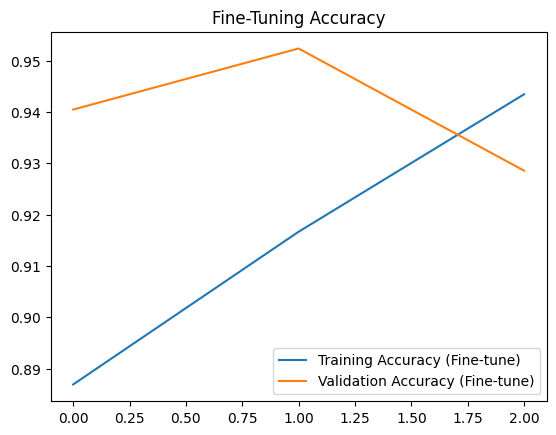

In [ ]:
# Unfreeze layers in the base model
base_model.trainable = True

# Recompile model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)

# Plot fine-tuning accuracy
plt.plot(history_ft.history['accuracy'], label='Training Accuracy (Fine-tune)')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy (Fine-tune)')
plt.legend()
plt.title('Fine-Tuning Accuracy')
plt.show()



## Testing the Model

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Preprocessing function for test images
def preprocess_image(image_path, target_size=(350, 350)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize
    return np.expand_dims(img_array, axis=0)

# Test folder
test_folder = '/content/drive/MyDrive/sdp_wildfire_satellite_shared/azerbaijan_wildfire_imagery/kaggle_fire_dataset_sample/test_dataset'
test_images = os.listdir(test_folder)

# Test each image and print results
for img_name in test_images:
    img_path = os.path.join(test_folder, img_name)
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)[0][0]
    predicted_class = 'Fire' if prediction > 0.5 else 'No Fire'
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Image: {img_name}, Predicted: {predicted_class}, Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: Копия -65.28623,48.07195.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: Копия -65.52272,49.2485.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: Копия -65.29028,48.05756.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: Копия -65.37765,48.05935.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: Копия -65.43008,48.02248.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: Копия -65.34674,48.02428.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Image: Копия -65.42863,48.10132.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: Копия -65.18435,48.88819.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image: Копия -65.54923,48.7518.jpg, Predicted: Fire, Confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━

# Evaluating Model Performance (Training, Validation, Test)

In [ ]:
# Evaluate on the training set
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9581 - loss: 0.1148
Training Loss: 0.1251, Training Accuracy: 0.9524
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 793ms/step - accuracy: 0.9335 - loss: 0.2233
Validation Loss: 0.2184, Validation Accuracy: 0.9345


In [ ]:
# Save the model with the .keras extension
model.save('/content/drive/MyDrive/sdp_wildfire_satellite_shared/inceptionv3_saved_model.h5')
# Or save with the .h5 extension
# model.save('/content/drive/MyDrive/sdp_wildfire_satellite_shared/inceptionv3_saved_model.h5')

# Additional Evaluation Metrics (Precision, Recall, F1 Score)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to get predictions
def get_predictions(generator):
    y_true = []
    y_pred = []

    for x_batch, y_batch in generator:
        y_true.extend(y_batch)
        y_pred.extend((model.predict(x_batch) > 0.5).astype("int32"))

        # If batch size is less than generator size, break
        if len(y_true) >= generator.samples:
            break

    return np.array(y_true), np.array(y_pred)

# Evaluate on the training set (train_generator)
y_true_train, y_pred_train = get_predictions(train_generator)
print("\nTraining Set Evaluation:")
print(f"Precision: {precision_score(y_true_train, y_pred_train)}")
print(f"Recall: {recall_score(y_true_train, y_pred_train)}")
print(f"F1 Score: {f1_score(y_true_train, y_pred_train)}")

# Evaluate on the validation set (val_generator)
y_true_val, y_pred_val = get_predictions(val_generator)
print("\nValidation Set Evaluation:")
print(f"Precision: {precision_score(y_true_val, y_pred_val)}")
print(f"Recall: {recall_score(y_true_val, y_pred_val)}")
print(f"F1 Score: {f1_score(y_true_val, y_pred_val)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Training Set Evaluation:
Precision: 0.9312714776632303
Recall: 0.811377245508982
F1 Score: 0.8672
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: math domain error